# Sesion 1: Taller de tecnicas de modelado de fluidos

## Solución Numérica usando Elementos Finitos (Galerkin Discontinuo)

**Por: Erick Urquilla, Universidad de Tennessee, Knoxville, USA**

Resolveremos las ecuaciones que gobiernan la dinámica de fluidos en capas delgadas, limitadas inferiormente por una superficie rígida y superiormente por una superficie libre. Estas se derivan de las ecuaciones de Navier-Stokes cuando el dominio espacial horizontal del fluido excede significativamente al vertical, manteniendo el equilibrio hidrostático y densidad constante:

$$
\frac{\partial h}{\partial t} + \frac{\partial}{\partial x}\left(hu\right) = 0
$$
$$
\frac{\partial}{\partial t}\left(hu\right) + \frac{\partial}{\partial x}\left(hu^2 + \frac{gh^2}{2}\right) = 0
$$

Aquí, $h$ es la altura del fluido, $u$ es la velocidad horizontal y $g$ es la aceleración de la gravedad. El movimiento del fluido está dictado exclusivamente por las ecuaciones de conservación de masa (primera) y momento (segunda).

## Paquetes Utilizados

En este proyecto, utilizaremos varios paquetes de Python que nos ayudarán a realizar diferentes tareas de manera eficiente. A continuación, se describen los paquetes que se utilizarán:

1. **numPy**
2. **matplotlib**
3. **time**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

## Scripts Utiliados

En esta sesion importaremos los siguientes scripts

1. **basis.py**
2. **evolve.py**
3. **integrator.py**

Puedes encontrar estos scripts en la misma ruta que este notebook

In [2]:
import basis
import evolve 
import integrator

## Parámetros de entrada

1. Dominio espacial de la simulación
2. Número de elementos y número de nodos interiores por elemento
3. Tiempo de la simulación y número de pasos
4. Número de puntos en la cuadratura de Gauss para integración numérica

In [3]:
# Parametros de entrada

# Dominio espacial de la simulacion 
x_inicial = 0 # (m) cooordenda inicial del dominio
x_final = 10 # (m) coordenada final del dominio

# Parametros del metodo de elementos finitos
N_elementos = 10 # numero de elementos
N_nodos = 2 # numero de nodos por elemento (por simplicidad solo consideramos N_nodos >= 2)

# Dominio temporal 
n_steps = 50 # numero de pasos temporales
t_limit = 1 # (s) tiempo final

# Integracion numerica con cuadratura de Gauss
n_gauss_poins = 20

## Generacion de malla

La generación de una malla es fundamental en el método de elementos finitos. La malla divide el dominio espacial en elementos finitos más pequeños, lo que permite aproximar la solución de la ecuación diferencial en cada uno de estos elementos. En el método Galerkin Discontinuo, cada elemento puede tener su propia solución polinómica, lo que permite capturar discontinuidades y variaciones abruptas en la solución.

**Ejercicio:** Dadas las coordenadas inicial `x_inicial`, coordenada final `x_final`, el número de elementos `N_elementos` y el número de nodos por elemento `N_nodos`. Codifica una malla cartesiana unidimensional con las coordenadas de los nodos interiores de cada elemento (elementos y nodos igualmente espaciados en una malla regular). El array resultado del ejercicio debe llamarse `malla`. La forma del array `malla` debe ser `(N_elementos, N_nodos)`. Es decir, el componente `malla[i][j]` representa la coordenada en `x` del nodo `j` del elemento `i`. 

![Malla](imagenes/malla.png)

In [20]:
print(f'Generando malla \nDominio físico: [{x_inicial},{x_final}] metros\nNúmero de elementos: {N_elementos}\nNodos por elemento: {N_nodos}\n')

# Generar coordenadas de los elementos y nodos en el espacio físico
malla = np.array([np.linspace(x_inicial + i * (x_final - x_inicial) / N_elementos, x_inicial + (i + 1) * (x_final - x_inicial) / N_elementos, N_nodos) for i in range(N_elementos)])

dx_elemento = (x_final - x_inicial) / N_elementos # longitud de cada elemento
dx_nodos = dx_elemento / (N_nodos - 1) # distancia entre nodos
malla = np.zeros((N_elementos, N_nodos)) # matriz que almacena las coordenadas de los nodos de cada elemento
for i in range(N_elementos):
    for j in range(N_nodos):
        malla[i, j] = x_inicial + i * dx_elemento + j * dx_nodos
    print(f'Nodos interiores de elemento {i}: {malla[i]} metros')

Generando malla 
Dominio físico: [0,10] metros
Número de elementos: 10
Nodos por elemento: 2

Nodos interiores de elemento 0: [0. 1.] metros
Nodos interiores de elemento 1: [1. 2.] metros
Nodos interiores de elemento 2: [2. 3.] metros
Nodos interiores de elemento 3: [3. 4.] metros
Nodos interiores de elemento 4: [4. 5.] metros
Nodos interiores de elemento 5: [5. 6.] metros
Nodos interiores de elemento 6: [6. 7.] metros
Nodos interiores de elemento 7: [7. 8.] metros
Nodos interiores de elemento 8: [8. 9.] metros
Nodos interiores de elemento 9: [ 9. 10.] metros


## Condiciones initiales

In [5]:
h = 1.0 + 0.1 * np.exp( - ( malla - 5.0 )**2 ) # Height (cm)
u = malla * 0.0 # Velocity (cm/s)

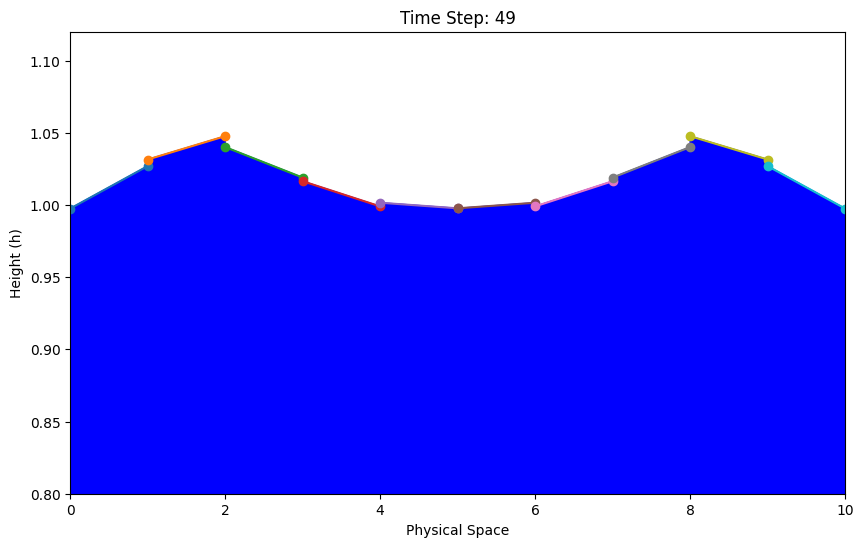

Done


In [6]:
element_number = np.arange(N_elementos)
element_lengths = malla[:,-1] - malla[:,0]

# generating reference space information
gauss_weights, basis_values_at_gauss_quad, basis_values_x_derivative_at_gauss_quad, basis_values_at_nodes = basis.generate_reference_space(malla, n_gauss_poins)

# compute mass matrix M_ij = integral phi_i(x) phi_j(x) dx and return the inverse matrix of M_ij
mass_matrix_inverse = evolve.compute_mass_matrix_inverse(element_lengths, gauss_weights, basis_values_at_gauss_quad)

# time step
time_step = np.array(t_limit/n_steps) 

# evolving in time the PDE
for number_of_t_step in np.arange(n_steps):

    # plotting
    clear_output(wait=True)  # Clear the output of the current cell    
    plt.figure(figsize=(10, 6))
    plt.clf()  # Clear the current figure
    for i in range(N_elementos):
        plt.plot(malla[i], h[i], linestyle='-', marker='o')
        plt.fill_between(malla[i], h[i], 0, color='blue')
    plt.ylim(0.8, 1.12)
    plt.xlim(0.0, 10.0)
    # plt.gca().set_aspect('equal', adjustable='box')  
    plt.xlabel('Physical Space')
    plt.ylabel('Height (h)')
    plt.title(f'Time Step: {number_of_t_step}')
    # plt.legend()
    # plt.grid(True)
    plt.show()
    time.sleep(0)  # Pause for a second to see the change

    # Fordward euler time stepping method
    h, u = integrator.euler_method( h, u, time_step, element_number, basis_values_at_gauss_quad, basis_values_x_derivative_at_gauss_quad, gauss_weights, element_lengths, basis_values_at_nodes, mass_matrix_inverse)

    # RK4 time stepping method
    # h, u = integrator.rk4_method( h, u, time_step, element_number, basis_values_at_gauss_quad, basis_values_x_derivative_at_gauss_quad, gauss_weights, element_lengths, basis_values_at_nodes, mass_matrix_inverse)

print(f'Done')